In [147]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fake-and-real-news-dataset


In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
from collections import Counter
import spacy
from heapq import nlargest
from transformers import BartTokenizer, BartForConditionalGeneration
sns.set()

In [149]:
df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [150]:
df.shape

(21417, 4)

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [152]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [153]:
df.duplicated().sum()

206

In [154]:
df.drop_duplicates(inplace = True)

In [155]:
df.shape

(21211, 4)

In [156]:
df['subject'].value_counts()

subject
politicsNews    11220
worldnews        9991
Name: count, dtype: int64

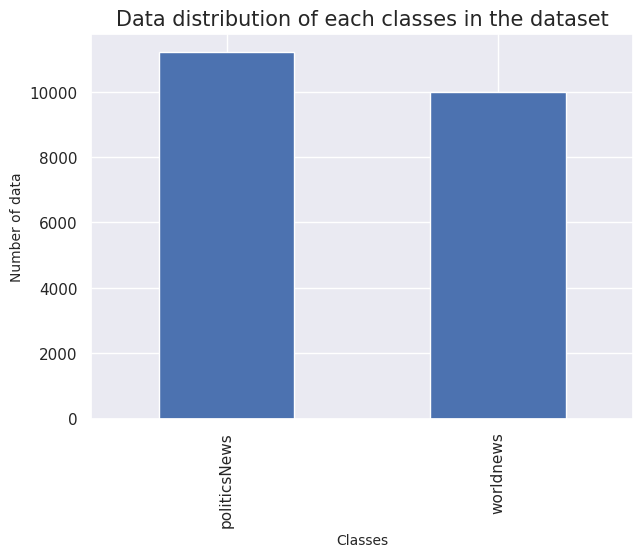

In [157]:
df['subject'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.title('Data distribution of each classes in the dataset', fontsize = 15)
plt.xlabel('Classes', fontsize = 10)
plt.ylabel('Number of data', fontsize = 10)
plt.show()

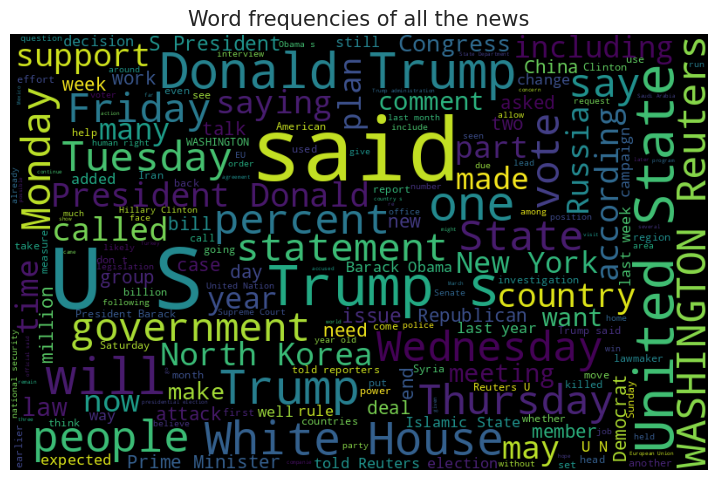

In [158]:
plt.figure(figsize = (9, 7))
all_sents = ' '.join([sentence for sentence in df['text']])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
plt.imshow(word_cloud)
plt.title('Word frequencies of all the news', fontsize = 15)
plt.axis('off')
plt.show()

In [159]:
def word_cloud(data, subject):
    plt.figure(figsize = (9, 7))
    sents = ' '.join([sentence for sentence in data['text'][data['subject'] == subject]])
    wordcl = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(sents)
    plt.imshow(wordcl)
    plt.axis('off')
    plt.show()

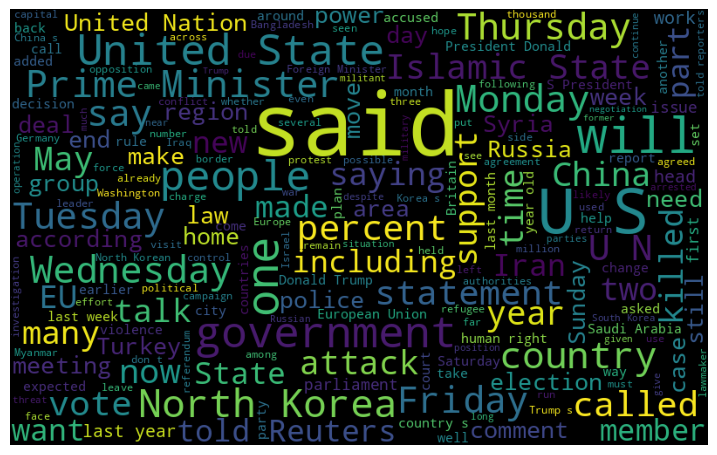

In [160]:
word_cloud(df, 'worldnews')

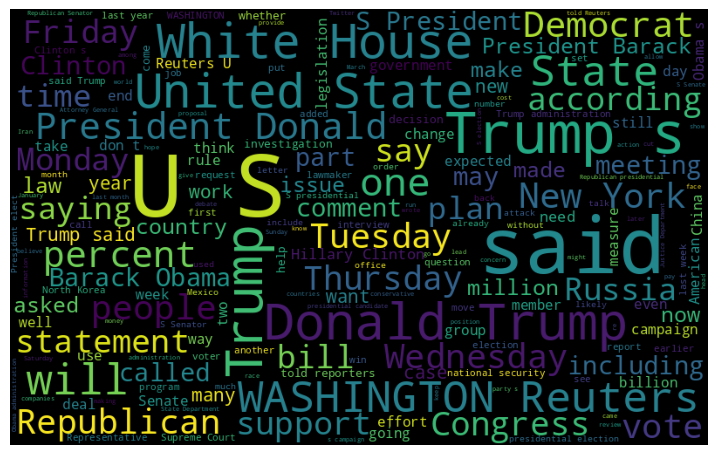

In [161]:
word_cloud(df, 'politicsNews')

In [162]:
def text_cleaning(text):
    try:
        return text.split('-')[1].strip()
    except IndexError as e:
        return text

In [163]:
sw = stopwords.words('english')

In [164]:
nlp = spacy.load('en_core_web_sm')

In [165]:
def text_preprocessing(text):
    text_n = text_cleaning(text)
    text_n = text_n.lower()
    text_n = re.sub('[^a-z]', ' ', text_n)
    text_n = re.sub('\s+[a-z]\s+', ' ', text_n)
    text_n = re.sub('\s+', ' ', text_n)
    words = [word for word in text_n.split() if word not in sw]
    return words

In [166]:
def extractive_summarization(text, num_sentences):
    words = text_preprocessing(text)
    word_freq = Counter(words)
    try:
        max_freq = max(word_freq.values())
        for word, freq in word_freq.items():
            word_freq[word] = freq / max_freq
        doc = nlp(text)
        all_sentences = [sentence.text for sentence in doc.sents]
        sents_freq = dict()
        for sentence in all_sentences:
            for word in sentence.split():
                if word in word_freq.keys():
                    if sentence not in sents_freq.keys():
                        sents_freq[sentence] = word_freq[word]
                    else:
                        sents_freq[sentence] += word_freq[word]
        n = nlargest(num_sentences, sents_freq, key = sents_freq.get)
        sentences = []
        for i in all_sentences:
            for j in n:
                if i == j:
                    sentences.append(i)
        return ' '.join(sentences)
    except ValueError as e:
        return 'This text is empty'

In [168]:
df = df.sample(500)

In [169]:
df['extractive_summarization'] = df['text'].apply(lambda x: extractive_summarization(x, 3))

In [170]:
df.head()

,title,text,subject,date,extractive_summarization
20713,Mongolian parliament ousts prime minister in l...,ULAANBAATAR (Reuters) - Mongolia s parliament ...,worldnews,"September 7, 2017",Mongolia s parliament voted to oust Prime Mini...
17979,Turkey to retry opposition lawmaker jailed on ...,ANKARA (Reuters) - Turkey will retry a lawmake...,worldnews,"October 9, 2017",Turkey will retry a lawmaker from the main opp...
7971,"U.S. 9/11 law exasperates Saudis, government s...",RIYADH/DUBAI (Reuters) - A U.S. law allowing l...,politicsNews,"September 29, 2016",A U.S. law allowing lawsuits against Saudi Ara...
18187,ICAN chief's message to Trump and Kim: nuclear...,GENEVA (Reuters) - The head of the Nobel Peace...,worldnews,"October 6, 2017",The head of the Nobel Peace Prize winning Inte...
18052,"Scottish independence case helped by ""Brexit c...",EDINBURGH (Reuters) - Britain s struggles to c...,worldnews,"October 8, 2017",Britain s struggles to chart a way out of the ...


In [171]:
df.reset_index(drop = True, inplace = True)

In [172]:
df.head()

,title,text,subject,date,extractive_summarization
0,Mongolian parliament ousts prime minister in l...,ULAANBAATAR (Reuters) - Mongolia s parliament ...,worldnews,"September 7, 2017",Mongolia s parliament voted to oust Prime Mini...
1,Turkey to retry opposition lawmaker jailed on ...,ANKARA (Reuters) - Turkey will retry a lawmake...,worldnews,"October 9, 2017",Turkey will retry a lawmaker from the main opp...
2,"U.S. 9/11 law exasperates Saudis, government s...",RIYADH/DUBAI (Reuters) - A U.S. law allowing l...,politicsNews,"September 29, 2016",A U.S. law allowing lawsuits against Saudi Ara...
3,ICAN chief's message to Trump and Kim: nuclear...,GENEVA (Reuters) - The head of the Nobel Peace...,worldnews,"October 6, 2017",The head of the Nobel Peace Prize winning Inte...
4,"Scottish independence case helped by ""Brexit c...",EDINBURGH (Reuters) - Britain s struggles to c...,worldnews,"October 8, 2017",Britain s struggles to chart a way out of the ...


In [173]:
df['text'][0]

'ULAANBAATAR (Reuters) - Mongolia s parliament voted to oust Prime Minister Jargaltulga Erdenebat, its website said late on Thursday, after his ruling Mongolian People s Party (MPP) was defeated in a July presidential election. No prime minister of Mongolia, a thinly populated and mineral-rich country sandwiched between Russia and China, has completed a four-year term since 2004. Of 73 members of parliament attending the vote, 42 were in favor of Erdenebat s removal. The outgoing prime minister noted that the country had seen 13 governments in the last 25 years.  The resignation of a government in a democratic parliament is a normal occurrence, but it can be harmful if a good thing goes beyond its norms,  Erdenebat said in a statement on parliament s website.  A former Soviet satellite, Mongolia transitioned to a parliamentary democracy in 1990.     I believe that dismissing government is a mistake that hinders the development of the country, rather than a positive mechanism of account

In [174]:
df['extractive_summarization'][0]

'Mongolia s parliament voted to oust Prime Minister Jargaltulga Erdenebat, its website said late on Thursday, after his ruling Mongolian People s Party (MPP) was defeated in a July presidential election. No prime minister of Mongolia, a thinly populated and mineral-rich country sandwiched between Russia and China, has completed a four-year term since 2004. The outgoing prime minister noted that the country had seen 13 governments in the last 25 years.  '

In [175]:
df['text'][1]

'ANKARA (Reuters) - Turkey will retry a lawmaker from the main opposition party after a court annulled his 25-year prison sentence but he will remain in custody, broadcaster NTV and opposition lawmakers said on Monday. Enis Berberoglu became a symbol for more than 50,000 people detained in the wake of a failed coup in July 2016. The chairman of his secular Republican People s Party (CHP) started a 425 km (265 mile) protest march from the capital Ankara to Istanbul when he was convicted and sentenced in June for military espionage. The court had said Berberoglu gave an opposition newspaper a video purporting to show Turkey s intelligence agency trucking weapons into Syria. Monday s decision to cancel the sentence came from the regional court of appeals, broadcaster NTV said. Berberoglu was the first CHP lawmaker to be jailed in a crackdown by President Tayyip Erdogan s government that has raised concerns among Turkey s Western allies and rights groups. More than 150,000 people, includin

In [176]:
df['extractive_summarization'][1]

'Turkey will retry a lawmaker from the main opposition party after a court annulled his 25-year prison sentence but he will remain in custody, broadcaster NTV and opposition lawmakers said on Monday. The court had said Berberoglu gave an opposition newspaper a video purporting to show Turkey s intelligence agency trucking weapons into Syria. Monday s decision to cancel the sentence came from the regional court of appeals, broadcaster NTV said.'

In [177]:
df['text'][2]

'RIYADH/DUBAI (Reuters) - A U.S. law allowing lawsuits against Saudi Arabia over the Sept. 11 attacks met a stony silence from Riyadh on Thursday but some Saudis bristled, saying the kingdom should curb business and security ties in response. The Senate and House of Representatives voted overwhelmingly on Wednesday to approve legislation that will allow the families of those killed in the 2001 attacks on the United States to seek damages from the Saudi government. Riyadh has always dismissed suspicions that it backed the attackers, who killed nearly 3,000 people under the banner of Islamist militant group al Qaeda. Fifteen out of the 19 hijackers were Saudi nationals.  The Saudi government financed an extensive lobbying campaign against the “Justice Against Sponsors of Terrorism Act”, or JASTA, in the run-up to the vote, and warned it would undermine the principle of sovereign immunity. But Saudi officials who had lobbied against the bill stopped short of threatening any retaliation if

In [178]:
df['extractive_summarization'][2]

'A U.S. law allowing lawsuits against Saudi Arabia over the Sept. 11 attacks met a stony silence from Riyadh on Thursday but some Saudis bristled, saying the kingdom should curb business and security ties in response. The Senate and House of Representatives voted overwhelmingly on Wednesday to approve legislation that will allow the families of those killed in the 2001 attacks on the United States to seek damages from the Saudi government. Riyadh has always dismissed suspicions that it backed the attackers, who killed nearly 3,000 people under the banner of Islamist militant group al Qaeda.'

In [180]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

In [182]:
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [197]:
def abstractive_summarization(text):
    token = tokenizer(text, max_length = 1024, truncation = True, return_tensors = 'pt')
    summ = model.generate(token['input_ids'], min_length = 150, max_length = 500, length_penalty = 2.0, num_beams = 7, early_stopping = True)
    return tokenizer.decode(summ[0], skip_special_tokens = True)

In [198]:
abstractive_summarization(df['text'][0])

'Mongolia s parliament voted to oust Prime Minister Jargaltulga Erdenebat. His ruling Mongolian People s Party (MPP) was defeated in a July presidential election. No prime minister of Mongolia, a thinly populated and mineral-rich country, has completed a four-year term since 2004. The MPP gained power in mid-2016 in elections in which it won 65 of parliament s 76 seats. The resignation of a government in a democratic parliament is a normal occurrence, but it can be harmful if a good thing goes beyond its norms,  Erdenebats said in a statement on parliament s website. The defeat was seen as a rejection of the MPP government s austerity policies and a reaction to allegations of corruption.'

In [199]:
abstractive_summarization(df['text'][1])

'Enis Berberoglu became a symbol for more than 50,000 people detained in the wake of a failed coup in July 2016. The chairman of his secular Republican People s Party (CHP) started a 425 km (265 mile) protest march from the capital Ankara to Istanbul when he was convicted and sentenced in June for military espionage. A court annulled his 25-year prison sentence but he will remain in custody, broadcaster NTV and opposition lawmakers said. Critics say Turkey is sliding toward greater authoritarianism. The government says such measures are necessary, given the vast security threats it is facing, and that the crackdown is necessary to protect the country from terrorism and terrorism-related threats. The crackdown has raised concerns among Turkey s Western allies and rights groups.'

In [200]:
abstractive_summarization(df['text'][2])

'U.S. law allowing lawsuits against Saudi Arabia over the Sept. 11 attacks met a stony silence from Riyadh. Some Saudis bristled, saying the kingdom should curb business and security ties in response. Riyadh has always dismissed suspicions that it backed the attackers, who killed nearly 3,000 people under the banner of Islamist militant group al Qaeda. The Saudi government financed an extensive lobbying campaign against the “Justice Against Sponsors of Terrorism Act”, or JASTA, in the run-up to the vote. But Saudi officials who had lobbied against the bill stopped short of threatening any retaliation if the law was passed. But the measure does nothing to ease long-standing friction in the alliance: President Barack Obama is increasingly seen by the kingdom as favoring their bitter rival Iran.'